<a href="https://colab.research.google.com/github/sg879/IIBProject/blob/main/Post_Test/Bayesian_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Variational Inference on Test Data

## Importing Packages

In [90]:
import matplotlib.pyplot as plt

In [91]:
%matplotlib inline

In [92]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax
from functools import partial
import jax
from scipy.stats import multivariate_normal

In [93]:
from jax.config import config
config.update("jax_enable_x64", True)

## Load Test Data

In [94]:
testx = jnp.load('drive/MyDrive/Project/Test/Testx.npy').astype('f').flatten()
truef = jnp.load('drive/MyDrive/Project/Test/Truef.npy').flatten()
inw = jnp.load('drive/MyDrive/Project/Test/Inputwin.npy')
outw = jnp.load('drive/MyDrive/Project/Test/Outputwin.npy')
truen = jnp.load('drive/MyDrive/Project/Test/Noise.npy')
testy = jsc.signal.convolve(testx, truef)
testy += truen*jnp.ones(jnp.shape(testy))

In [95]:
t = jnp.shape(testx)[0]-1
n = jnp.shape(testy)[0] - t - 1
dt = inw/t
timex = jnp.linspace(0.0, t*dt, t+1)
timey = jnp.linspace(0.0, (n+t)*dt, t+n+1)
timef = jnp.linspace(0.0, n*dt, n+1)

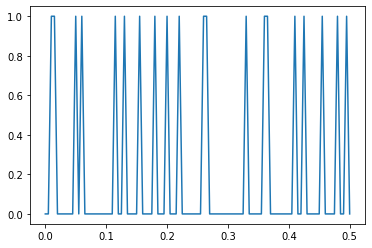

In [96]:
plt.plot(timex, testx)

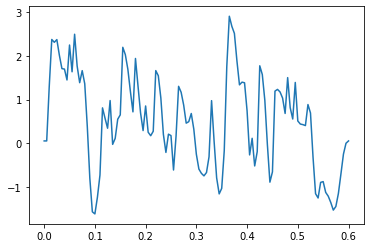

In [97]:
plt.plot(timey, testy)

## Function Definitions

### Cholesky Decomposition

In [98]:
@jit
def Broke_Chol(Symmetric_Matrix):
  F_size = jnp.shape(Symmetric_Matrix)[0]
  return jnp.linalg.cholesky(Symmetric_Matrix + 10.0**(-6.0)*jnp.eye(F_size))

In [99]:
@jit
def Good_Chol(Symmetric_Matrix):
  return jnp.linalg.cholesky(Symmetric_Matrix)

#### Test Cholesky

In [100]:
print(Vec_SE(timex[:3], timex[:3], 100.0, 0.1))

[[0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]]


In [101]:
print(Good_Chol(Vec_SE(timex[:3], timex[:3], 100.0, 0.1)))

[[nan  0.  0.]
 [nan nan  0.]
 [nan nan nan]]


In [102]:
print(jnp.linalg.cholesky(Vec_SE(timex[:3], timex[:3], 100.0, 0.1)))

[[nan  0.  0.]
 [nan nan  0.]
 [nan nan nan]]


In [103]:
print(Broke_Chol(Vec_SE(timex[:3], timex[:3], 100.0, 0.1)))

[[0.100005   0.         0.        ]
 [0.099995   0.00141419 0.        ]
 [0.099995   0.00070708 0.00122476]]


In [104]:
print(jnp.linalg.cholesky(Vec_SE(timex[:3], timex[:3], 100.0, 0.1)+10**(-6.0)*jnp.eye(3)))

[[0.100005   0.         0.        ]
 [0.099995   0.00141419 0.        ]
 [0.099995   0.00070708 0.00122476]]


### Lower Triangular Matrix **Cannot be jit-ed**

In [105]:
def Build_L(L_Array):

  L_Array_size = jnp.shape(L_Array)[0]

  M = jnp.round((-0.5 + jnp.sqrt(0.25 + 2*L_Array_size))).astype(jnp.integer)

  L_MM = jnp.zeros((M, M))

  return L_MM.at[jnp.tril_indices(M)].set(L_Array)

#### Lower Triangular Matrix Test

In [106]:
test_m = 10
test_triangle_size = jnp.round(test_m*(test_m + 1)/2).astype(jnp.integer)
test_eye = jnp.eye(test_m).at[jnp.tril_indices(test_m)].get()

In [107]:
print(Build_L(5*jnp.ones((test_triangle_size,))))

[[5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 5. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 5. 5. 0. 0. 0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 0. 0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 5. 0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 5. 5. 0. 0. 0. 0.]
 [5. 5. 5. 5. 5. 5. 5. 0. 0. 0.]
 [5. 5. 5. 5. 5. 5. 5. 5. 0. 0.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 0.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]


In [108]:
print(Build_L(test_eye))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### SE Prior

#### SE Covariance Function

In [109]:
@jit
def Squared_exp(I, J, Ell, Sigma_f):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2*Ell**2.0))

In [110]:
Vec_SE = jit(vmap(vmap(Squared_exp, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

##### SE Test

In [111]:
testSEx = jnp.asarray([0.0, 0.3, 0.6, 0.9])

In [112]:
testSEy = jnp.asarray([0.0, 0.3, 0.6])

In [113]:
print(testSEx)

[0.  0.3 0.6 0.9]


In [114]:
print(Vec_SE(testSEx, testSEx, 0.2, 3.0))

[[9.00000000e+00 2.92187221e+00 9.99809688e-02 3.60587677e-04]
 [2.92187221e+00 9.00000000e+00 2.92187221e+00 9.99809688e-02]
 [9.99809688e-02 2.92187221e+00 9.00000000e+00 2.92187221e+00]
 [3.60587677e-04 9.99809688e-02 2.92187221e+00 9.00000000e+00]]


In [115]:
print(Vec_SE(testSEx, testSEy, 0.2, 3.0))

[[9.00000000e+00 2.92187221e+00 9.99809688e-02]
 [2.92187221e+00 9.00000000e+00 2.92187221e+00]
 [9.99809688e-02 2.92187221e+00 9.00000000e+00]
 [3.60587677e-04 9.99809688e-02 2.92187221e+00]]


### Variational Bound (ELBO)

#### KL Divergence

In [116]:
@jit
def Kl_div(V_M, L_MM):
  M = jnp.shape(V_M)[0]
  return 0.5*(-jnp.sum(jnp.log(jnp.square(jnp.diag(L_MM)))) +
              jnp.linalg.norm(L_MM)**2 + jnp.linalg.norm(V_M)**2 - M)

##### KL Divergence Test **Not Carried Out**

In [117]:
#test_Lmat = jnp.eye(3)
test_Vu = 0.5*jnp.ones(3)

In [118]:
#print(kl_div(test_Vu, test_Lmat))

#### Log-Likelihood

In [119]:
@jit
def Loglikely(Sigma_n, F_Sample, Testx, Testy):

  # Convolve the x-data and the f-sample together
  Y_mean = jsc.signal.convolve(Testx, F_Sample)

  # Shape of output-data
  D = jnp.shape(Y_mean)[0]

  # Difference between y-data and the mean 
  Diff = Testy - Y_mean

  return 0.5*(-D*jnp.log(2*jnp.pi) - 2*D*jnp.log(Sigma_n) - 
              jnp.linalg.norm(Diff)**2/Sigma_n**2)

In [193]:
Vec_Loglikely = jit(vmap(Loglikely, in_axes = [None, 0, None, None]))

###### Log-Likelihood Test

In [120]:
print(jsc.stats.multivariate_normal.logpdf(testy, jnp.convolve(testx, truef), 0.05**2*jnp.eye(t+n+1)))

190.79204258226773


In [121]:
print(Loglikely(0.05, truef, testx, testy))

190.7920425822675


In [197]:
print(Vec_Loglikely(0.05, jnp.vstack((truef, truef)), testx, testy))

[190.79204258 190.79204258]


#### Expected Log-Likelihood

In [209]:
#@partial(jit, static_argnums = (0,1))
def Exp_Loglikely(Number_f, M, Subkey, Sigma_f, Ell_f, Sigma_n, Z_M, V_M, L_MM, K_NN, 
                  Timex, Testx, Timey, Testy):
  
  # Get vector of filter times
  Dt = Timex[1]
  T = jnp.shape(Testx)[0] - 1
  N = jnp.shape(Testy)[0] - T - 1

  F_times = jnp.linspace(0.0, Timey[-1]-Timex[-1], N + 1)

  # Get the relevant matrices
  K_MN = Vec_SE(Z_M, F_times, Ell_f, Sigma_f)
  K_MM = Vec_SE(Z_M, Z_M, Ell_f, Sigma_f)
  C_MM = jnp.linalg.cholesky(K_MM + 1e-6)
  BT = jsc.linalg.solve_triangular(C_MM, K_MN, lower = True, overwrite_b = True)

  # Build the mean vector and covariance matrix of q(f)
  Mu_q = V_M @ BT
  V_q = K_NN + BT.T @ (L_MM @ L_MM.T - jnp.eye(M)) @ BT

  # Get the samples of f
  Sampled_fs = random.multivariate_normal(Subkey, Mu_q, V_q, shape = (Number_f,))

  # Get the mean log-likelihood with each of these fs
  Likelihoods = Vec_Loglikely(Sigma_n, Sampled_fs, Testx, Testy)

  return F_times, Mu_q, V_q, Dt, T, N, Sampled_fs, Likelihoods, jnp.mean(Likelihoods)


##### Expected Log-Likelihood Test

In [210]:
test_number_f = 10000
test_m = 11
test_key = random.PRNGKey(10)
test_eye = jnp.eye(test_m).at[jnp.tril_indices(test_m)].get()
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = jnp.linspace(0.0, timef[-1], test_m)
test_v_m = jnp.exp(-75*testz_m)
test_l_mm = Build_L(test_eye)
test_k_nn = Vec_SE(timef, timef, test_ell_f, test_sigma_f)

In [ ]:
test_Ex = 

In [211]:
%%capture
print(jnp.linalg.cholesky(Exp_Loglikely(1, test_m, test_key, test_sigma_f, test_ell_f, test_sigma_n, test_z_m, 
                    test_v_m, test_l_mm, test_k_nn, timex, testx, timey, testy)[2]))

In [212]:
test_mu_q = Exp_Loglikely(1, test_m, test_key, test_sigma_f, test_ell_f, test_sigma_n, test_z_m, 
                    test_v_m, test_l_mm, test_k_nn, timex, testx, timey, testy)[1]

In [213]:
test_v_q = Exp_Loglikely(1, test_m, test_key, test_sigma_f, test_ell_f, test_sigma_n, test_z_m, 
                    test_v_m, test_l_mm, test_k_nn, timex, testx, timey, testy)[2]

In [217]:
test_samples_f = Exp_Loglikely(test_number_f, test_m, test_key, test_sigma_f, 
                               test_ell_f, test_sigma_n, test_z_m, test_v_m, 
                               test_l_mm, test_k_nn, timex, testx, timey, testy)[6]

In [218]:
print(test_mu_q)

[0.99999898 1.06831145 0.98208968 0.80565478 0.61188347 0.4437444
 0.31387242 0.21917198 0.15201341 0.10503992 0.07242631 0.04987598
 0.0343184  0.02360091 0.01622933 0.01116141 0.0076694  0.00526385
 0.00362333 0.00250741 0.00171163]


In [219]:
print(jnp.mean(test_samples_f, axis=0))

[ 0.97043617  1.0459039   0.97477539  0.81505439  0.63289291  0.46804735
  0.33549271  0.23414696  0.15717143  0.09965303  0.05964824  0.03552501
  0.02220887  0.01317033  0.00619959  0.0038984   0.00696934  0.00886759
  0.00443596 -0.00126225 -0.00177281]


In [221]:
test_likelihoods = Exp_Loglikely(test_number_f, test_m, test_key, test_sigma_f, 
                               test_ell_f, test_sigma_n, test_z_m, test_v_m, 
                               test_l_mm, test_k_nn, timex, testx, timey, testy)[-2]

In [222]:
print(test_samples_f == random.multivariate_normal(test_key, test_mu_q, test_v_q, shape = (test_number_f, )))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [223]:
print(Exp_Loglikely(test_number_f, test_m, test_key, test_sigma_f, 
                               test_ell_f, test_sigma_n, test_z_m, test_v_m, 
                               test_l_mm, test_k_nn, timex, testx, timey, testy)[-1])

-137597.612360929
